# Simulate PWV effet on differential color light curves For Multiple Airmass

- author Sylvie Dagoret-Campagne
- creation date : 2024/09/10
- update : 2024/08/10

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

from astropy.io import fits
from astropy import units as u
from astropy import constants as c

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


In [2]:
from scipy import interpolate
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree, BallTree

In [3]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Be sure to run this notebook in conda environment named conda_py310


## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

### libradtran Emulator

In [4]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.2


In [5]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo("AUXTEL")
#emul = ObsAtmo("LSST")

AUXTEL site name validated as LSST observatory


In [6]:
WL = emul.GetWL()

#### Library to fit atmosphere

In [7]:
import sys
sys.path.append('../lib')
#import libAtmosphericFit

#### Library that encapsulate calculations for Photometric correction

In [8]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


In [9]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [10]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

#### library rubin_sim defining LSST parameters, namely for photometric calculations

In [11]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

In [ ]:
# reference flux in Jy
F0 = ((0.*u.ABmag).to(u.Jy)).value
F0

## Configuration

In [12]:
am0 =1.20    # airmass
pwv0 = 3.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [13]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)
pc1 = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)
pc2 = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)
pc3 = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/Users/sylvie/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

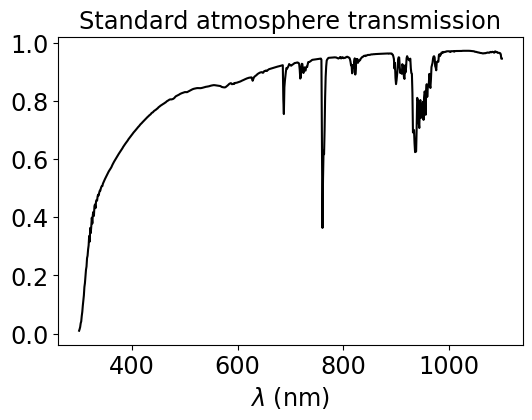

In [14]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

### Check LSST instrument throughput

Photometric Correction package should find the instrumental passband of LSST

Text(0.5, 1.0, 'Instrument throughput (auxtel)')

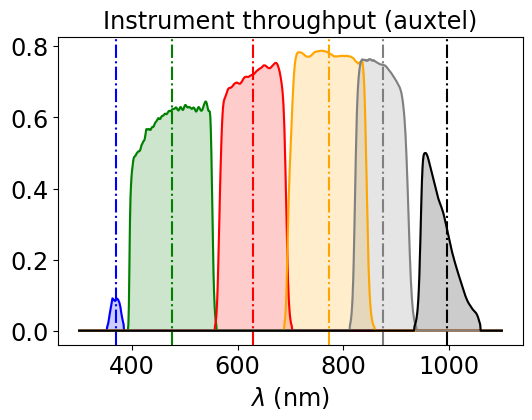

In [15]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput (auxtel)")

### Check LSST standard Filter throughputs

Text(0.5, 1.0, 'Total filter throughput (auxtel)')

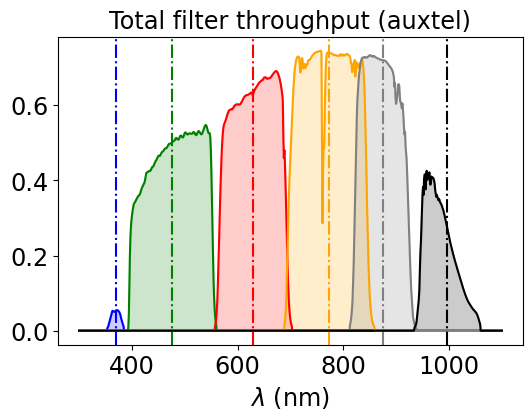

In [16]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total filter throughput (auxtel)")

## Variation of PWV

In [17]:
am = 1.2
oz = 300
tau= 0.04
beta = 1
all_pwv = np.arange(0,10,0.5)
NPWV = len(all_pwv)

In [18]:
pc.CalculateMultiObs(am,all_pwv,oz,tau,beta)

### PWV variation :  Observed filter and normalized response

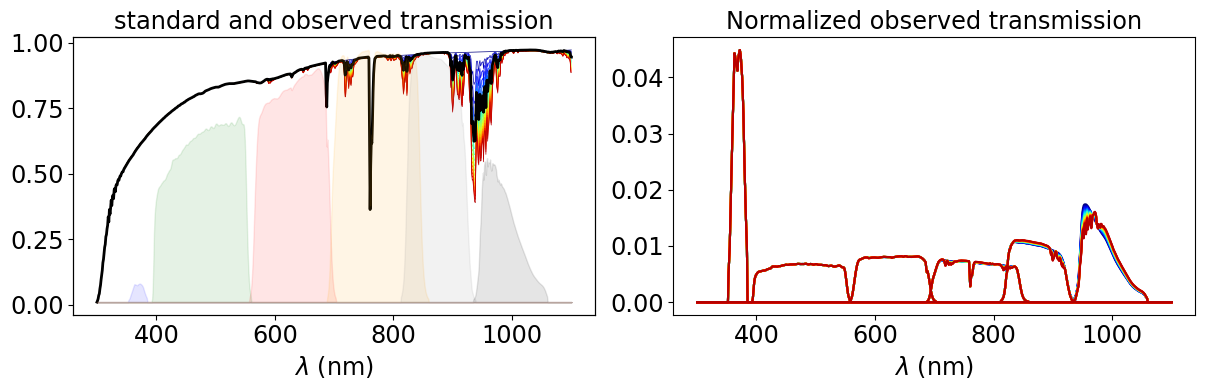

In [19]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,4))

# Figure 1
axs=fig.add_subplot(1,2,1)
for index,pwv in enumerate(all_pwv):
  
    atm = pc.coll_atm_nonstd[index]
    
    label = f"pwv={pwv:.1f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



# Figure 2
axs=fig.add_subplot(1,2,2)

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


for idx_pwv,pwv in enumerate(all_pwv):
    
    label = f"pwv={pwv:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_pwv][ifilt,:]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  


plt.tight_layout()
plt.show()



## Flat SED

In [53]:
# Find the throughputs directory 
#fdir = os.getenv('RUBIN_SIM_DATA_DIR')
fdir = get_data_dir()
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')

In [54]:
the_sed_flat = Sed()
the_sed_flat.set_flat_sed()
the_sed_flat.name = 'flat'

In [55]:
zmag = 20.0
flux_norm = the_sed_flat.calc_flux_norm(zmag, pc.bandpass_total_std['z'])
the_sed_flat.multiply_flux_norm(flux_norm)

### Check the calculation of the Magnitude and the ADC counts (observation)

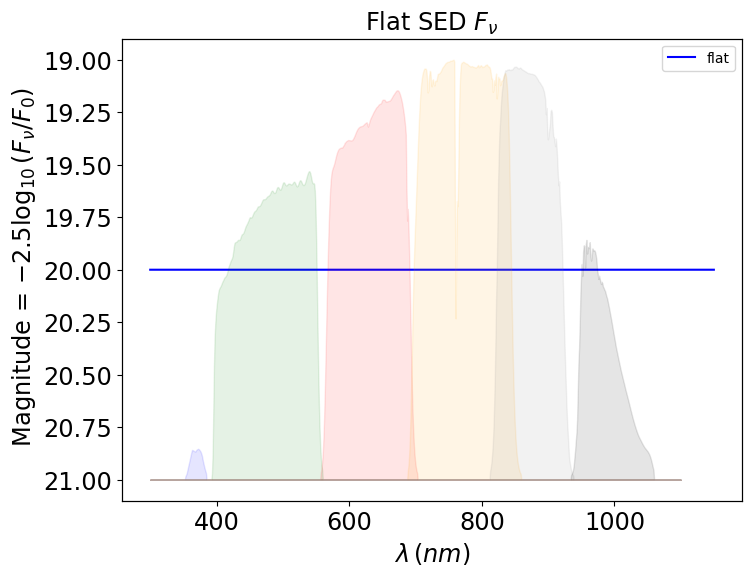

In [150]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(the_sed_flat .wavelen,-2.5*np.log10(the_sed_flat.fnu/F0),"b-",label=the_sed_flat.name)

ax.legend()
#ax.set_ylim(1e-17,1e-14)
#ax.set_xlim(300.,2000.)
ax.set_title("Flat SED $F_\\nu$")
ax.set_ylabel(" Magnitude = $-2.5 \log_{10}(F_\\nu/F_0)$")
ax.set_xlabel("$\\lambda \, (nm)$")
ax.yaxis.set_inverted(True)


ax3 = ax.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax3.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax3.set_yticks([])
    

## Generate a series of SED with different slopes in Fnu

In [62]:
photom_wl= FILTERWL[:,0]
lambda0z = photom_wl[4]

In [145]:
all_alphas = np.arange(-3.,3.1,0.2)

In [152]:
all_seds = []
zmag = 20.0
for idx,alpha in enumerate(all_alphas):
    label =f"sed{idx}_slope={alpha:.1f}"
    the_wl = the_sed_flat.wavelen
    the_fnu = np.power(the_wl/lambda0z,alpha)
    the_sed = Sed()
    the_sed.set_sed(the_wl, flambda=None, fnu=the_fnu,name=label)
   
    flux_norm = the_sed.calc_flux_norm(zmag, pc.bandpass_total_std['z'])
    the_sed.multiply_flux_norm(flux_norm)
    all_seds.append(the_sed)

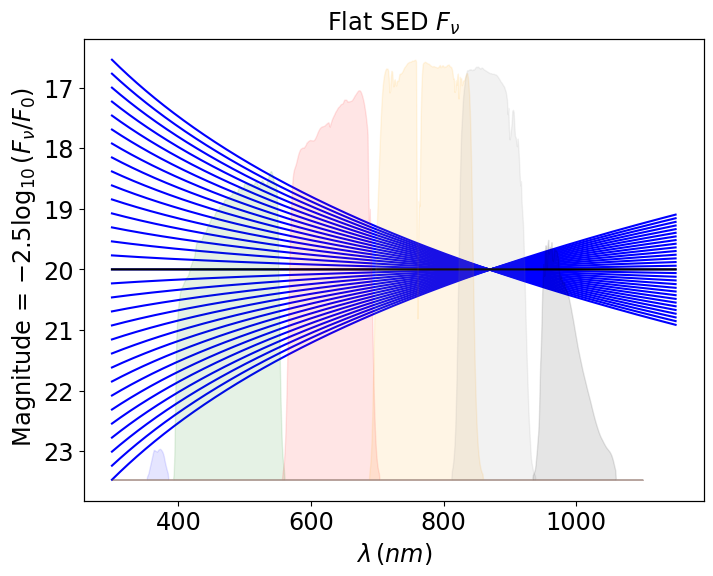

In [153]:
fig,ax = plt.subplots(1,1,figsize=(8,6))


for idx,the_sed in enumerate(all_seds):
    ax.plot(the_sed.wavelen,-2.5*np.log10(the_sed.fnu/F0),"b-",label=the_sed.name)

ax.plot(the_sed_flat .wavelen,-2.5*np.log10(the_sed_flat.fnu/F0),"k-",label=the_sed_flat.name)

#ax.legend()
#ax.set_ylim(1e-17,1e-14)
#ax.set_xlim(300.,2000.)
ax.set_title("Flat SED $F_\\nu$")
ax.set_ylabel(" Magnitude = $-2.5 \log_{10}(F_\\nu/F_0)$")
ax.set_xlabel("$\\lambda \, (nm)$")
ax.yaxis.set_inverted(True)


ax3 = ax.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax3.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax3.set_yticks([])

In [154]:
mags_std = {}
for index,f in enumerate(filter_tagnames) :
    mags_std[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
mags_std["g-r"] = mags_std["g"]- mags_std["r"]  
mags_std["z-y"] = mags_std["z"]- mags_std["y"]   
dfmag = pd.DataFrame(mags_std, index=[the_sed.name]).T
dfmag

,sed30_slope=3.0
u,22.795946
g,21.940815
r,21.051869
i,20.395624
z,20.000000
y,19.605588
g-r,0.888946
z-y,0.394412


In [155]:
photoparams = set_photometric_parameters(30, 1 , readnoise=None)
adcs_stdmag = {}
for index,f in enumerate(filter_tagnames) :
    adcs_stdmag[f] = -2.5*np.log10(the_sed.calc_adu(pc.bandpass_total_std[f],photoparams))
adcs_stdmag["g-r"] = adcs_stdmag["g"]- adcs_stdmag["r"]  
adcs_stdmag["z-y"] = adcs_stdmag["z"]- adcs_stdmag["y"]      
dfadu = pd.DataFrame(adcs_stdmag, index=[the_sed.name]).T
dfadu

,sed30_slope=3.0
u,-4.408634
g,-9.449429
r,-10.115524
i,-10.853117
z,-10.674300
y,-9.892797
g-r,0.666095
z-y,-0.781503


## Simulate multi atmospheres

In [156]:
am = 1.2
am1 = 1.0
am2 = 1.5
am3 = 2.0
oz = 300
tau= 0.04
beta = 1
all_pwv = np.arange(0,15.,0.5)
NPWV = len(all_pwv)

In [157]:
pc.CalculateMultiObs(am,all_pwv,oz,tau,beta)
pc1.CalculateMultiObs(am1,all_pwv,oz,tau,beta)
pc2.CalculateMultiObs(am2,all_pwv,oz,tau,beta)
pc3.CalculateMultiObs(am3,all_pwv,oz,tau,beta)

/Users/sylvie/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


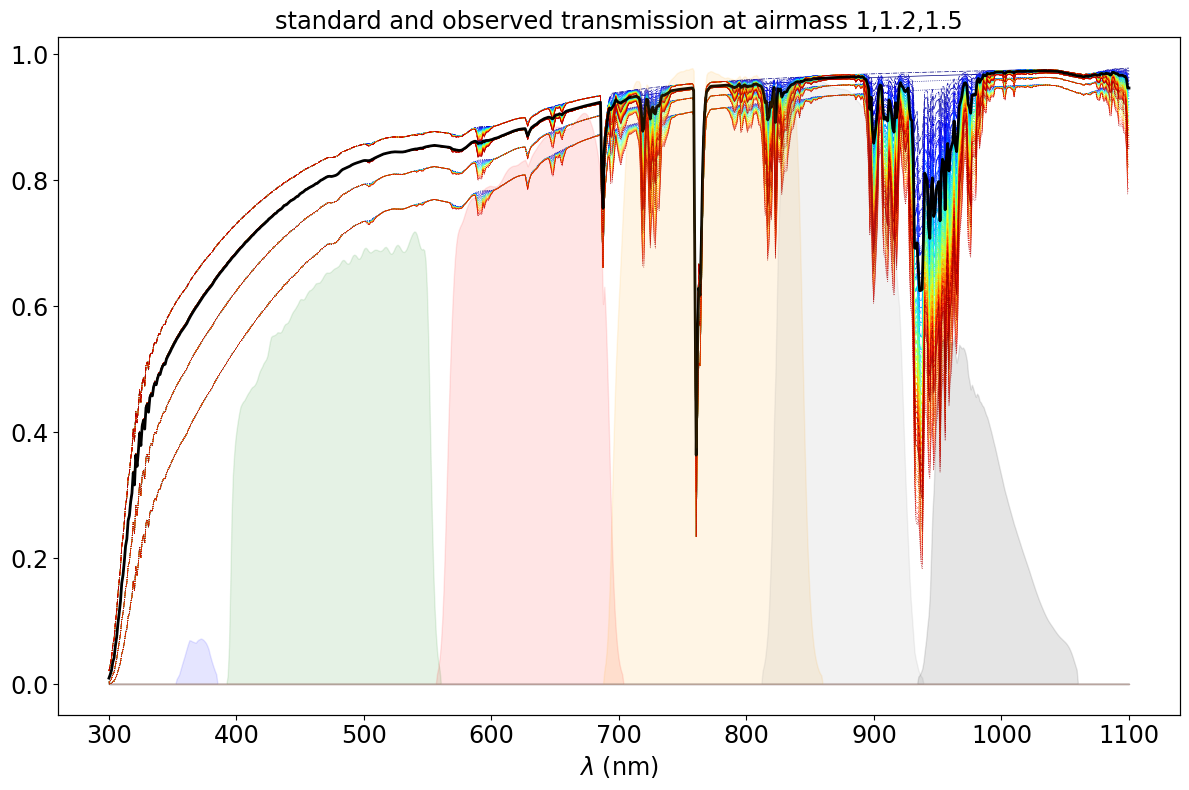

In [158]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,8))

# Figure 1
axs=fig.add_subplot(1,1,1)
for index,pwv in enumerate(all_pwv):

    #atm = pc.coll_bandpass_total_nonstd[index]
    atm = pc.coll_atm_nonstd[index]
    atm1 = pc1.coll_atm_nonstd[index]
    atm2 = pc2.coll_atm_nonstd[index]
    atm3 = pc3.coll_atm_nonstd[index]
    
    label = f"pwv={pwv:.1f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
    axs.plot(pc1.WL,atm1,color=all_colors[index],ls="-.",lw=0.5)
    axs.plot(pc2.WL,atm2,color=all_colors[index],ls=":",lw=0.5)
    axs.plot(pc3.WL,atm3,color=all_colors[index],ls=":",lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission at airmass 1,1.2,1.5")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])


plt.tight_layout()
plt.show()


## Note the passbands for each of the PWV conditions are in pc.coll_bandpass_total_nonstd

In [159]:
len(pc.coll_bandpass_total_nonstd)

30

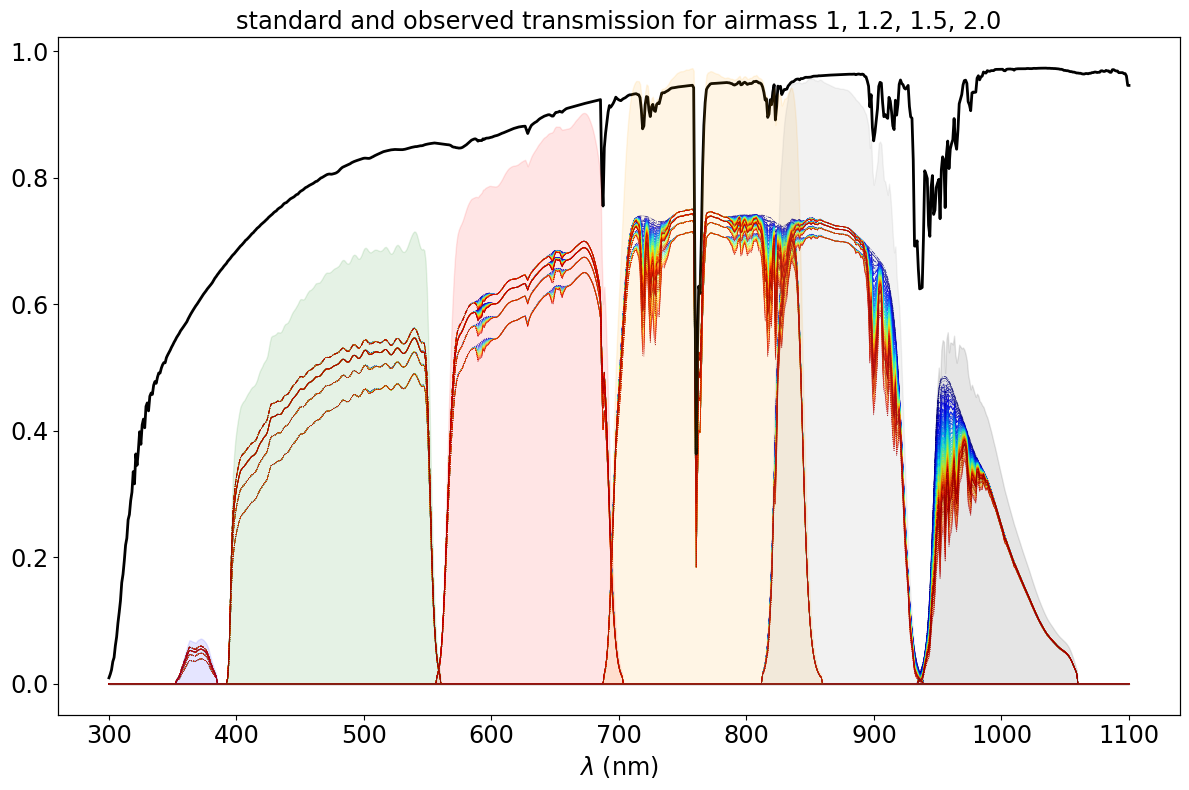

In [162]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,8))

# Figure 1
axs=fig.add_subplot(1,1,1)
for index,pwv in enumerate(all_pwv):
  
    atm_bands = pc.coll_bandpass_total_nonstd[index]
    atm_bands1 = pc1.coll_bandpass_total_nonstd[index]
    atm_bands2 = pc2.coll_bandpass_total_nonstd[index]
    atm_bands3 = pc3.coll_bandpass_total_nonstd[index]
    
    label = f"pwv={pwv:.1f}" 

    for f in filter_tagnames: 
        axs.plot(atm_bands[f].wavelen,atm_bands[f].sb,color=all_colors[index],label=label,lw=0.5)
        axs.plot(atm_bands1[f].wavelen,atm_bands1[f].sb,color=all_colors[index],ls="-.",lw=0.5)
        axs.plot(atm_bands2[f].wavelen,atm_bands2[f].sb,color=all_colors[index],ls=":",lw=0.5)
        axs.plot(atm_bands3[f].wavelen,atm_bands3[f].sb,color=all_colors[index],ls=":",lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission for airmass 1, 1.2, 1.5, 2.0")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])


plt.tight_layout()
plt.show()


## Compute the Magnitudes in all these transmission

- in all_df_magcol

In [164]:
def ComputeColors(the_pc,the_sed1,the_sed2):
    """
    Compute G-R and Z-R for both SED 1 and 2 independently for each at pwv conditions in the_pc
    Return the dataframe  in color for both sed independently
    """
    
    all_df_magcol = []
    for index,pwv in enumerate(all_pwv):
        atm_bands = the_pc.coll_bandpass_total_nonstd[index]
        mags_pwv1 = {}
        mags_pwv2 = {}
        madus_pwv1 = {}
        madus_pwv2 = {}
        for f in filter_tagnames: 
            mags_pwv1[f] = the_sed1.calc_mag(atm_bands[f])
            mags_pwv2[f] = the_sed2.calc_mag(atm_bands[f])
            madus_pwv1[f] = -2.5*np.log10(the_sed1.calc_adu(atm_bands[f],photoparams))
            madus_pwv2[f] = -2.5*np.log10(the_sed2.calc_adu(atm_bands[f],photoparams))
        # AB colors for star 1
        mags_pwv1["g-r"] = mags_pwv1["g"]- mags_pwv1["r"]  
        mags_pwv1["z-y"] = mags_pwv1["z"]- mags_pwv1["y"] 
        # AB colors for star 2
        mags_pwv2["g-r"] = mags_pwv2["g"]- mags_pwv2["r"]  
        mags_pwv2["z-y"] = mags_pwv2["z"]- mags_pwv2["y"] 
        # ADU mag colors for star 1
        # MADU colors for star 1
        madus_pwv1["g-r"] = madus_pwv1["g"]- madus_pwv1["r"]  
        madus_pwv1["z-y"] = madus_pwv1["z"]- madus_pwv1["y"] 
        # MADU colors for star 2
        madus_pwv2["g-r"] = madus_pwv2["g"]- madus_pwv2["r"]  
        madus_pwv2["z-y"] = madus_pwv2["z"]- madus_pwv2["y"] 
        
        df1 = pd.DataFrame(mags_pwv1, index=["abmag_1"]).T
        df2 = pd.DataFrame(mags_pwv2, index=["abmag_2"]).T
        df3 = pd.DataFrame(madus_pwv1, index=["instmag_1"]).T
        df4 = pd.DataFrame(madus_pwv2, index=["instmag_2"]).T
        df = pd.concat([df1,df2,df3,df4],axis=1)
        all_df_magcol.append(df)
        
    return all_df_magcol
   

In [165]:
def ComputeRelativeDiffColor(the_all_df_magcol):
    """
    Compute the relative color difference
    """

    df_diffcol = pd.DataFrame(columns=["pwv","Czy1_Czy2_abmag","Czy1_Czy2_instmag"])
    for index,pwv in enumerate(all_pwv):
        the_df = the_all_df_magcol[index]
        DCzyabmag = the_df.loc["z-y","abmag_1"] - the_df.loc["z-y","abmag_2"]
        DCzyadumag = the_df.loc["z-y","instmag_1"] - the_df.loc["z-y","instmag_2"]
        df_diffcol.loc[index] = [pwv,DCzyabmag,DCzyadumag]

    # Relative difference color is in mmag for plotting
    df_diffcol["Czy1_Czy2_abmag_rel"] =  (df_diffcol["Czy1_Czy2_abmag"] - df_diffcol.loc[0,"Czy1_Czy2_abmag"])*1000
    df_diffcol["Czy1_Czy2_instmag_rel"] =  (df_diffcol["Czy1_Czy2_instmag"] - df_diffcol.loc[0,"Czy1_Czy2_instmag"])*1000

    # differentiation  mmag per mm
    dx = np.diff(df_diffcol.pwv.values).mean()
    dy1 = np.diff(df_diffcol["Czy1_Czy2_abmag_rel"].values)
    dy2 = np.diff(df_diffcol["Czy1_Czy2_instmag_rel"].values)
    z_y0 = df_diffcol.loc[0,"Czy1_Czy2_abmag"]
    return df_diffcol

In [167]:
all_zerocoldiff = []
all_colordiffcurves = []

for idx,the_sed in enumerate(all_seds):
    the_sed1 = the_sed_flat
    the_sed2 = the_sed
    all_df_magcol = ComputeColors(pc,the_sed1,the_sed2)
    df_diffcol = ComputeRelativeDiffColor(all_df_magcol)
    # the color difference for PWV = 0
    z_y0 = df_diffcol.loc[0,"Czy1_Czy2_abmag"]
    all_zerocoldiff.append(z_y0)
    all_colordiffcurves.append(all_colordiffcurves) 
    

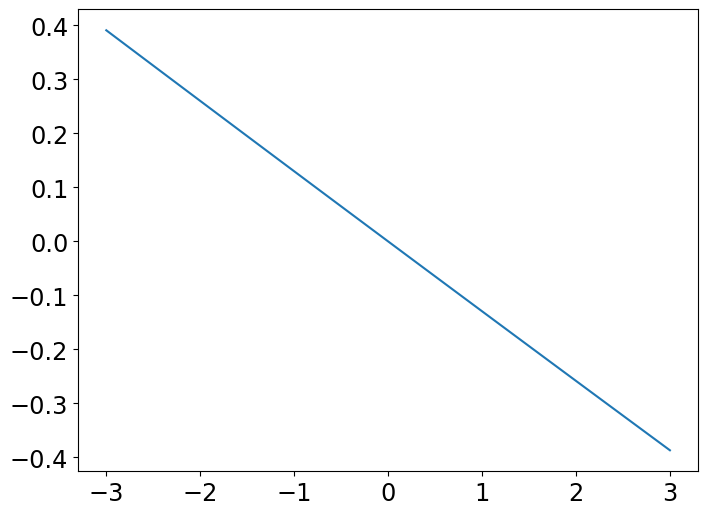

In [169]:
plt.plot(all_alphas,all_zerocoldiff)

In [ ]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=-.26, vmax=.26)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)


In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

for idx,idx_pair in enumerate(good_indexes):
    the_color_curve = all_color_curves[idx]
    z_y0 = the_color_curve.loc[0,"Czy1_Czy2_abmag"]
    the_color = scalarMap.to_rgba(z_y0, alpha=1)
    ax.plot(the_color_curve.pwv,the_color_curve.Czy1_Czy2_instmag_rel,c=the_color)

cbar = fig.colorbar(scalarMap,ax=ax, orientation='vertical', label='Z-Y(pwv=0) (mag)')    
ax.set_xlabel("pwv (mm)")    
ax.set_ylabel("Czy1_Czy2_abmag_rel (mmag)")
ax.set_title("Relative color difference Z-Y from star1,star2")


In [ ]:
len(all_df_magcol)

In [ ]:
all_df_magcol[0]

In [ ]:
df_diffcol = ComputeRelativeDiffColor(all_df_magcol)
df_diffcol1 = ComputeRelativeDiffColor(all_df_magcol1)
df_diffcol2 = ComputeRelativeDiffColor(all_df_magcol2)
df_diffcol3 = ComputeRelativeDiffColor(all_df_magcol3)

In [ ]:
# differentiation  mmag per mm
dx = np.diff(df_diffcol.pwv.values).mean()
dy1 = np.diff(df_diffcol["Czy1_Czy2_abmag_rel"].values)
dy2 = np.diff(df_diffcol["Czy1_Czy2_instmag_rel"].values)
z_y0 = df_diffcol.loc[0,"Czy1_Czy2_abmag"]

In [ ]:
df_diffcol1

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
#df_diffcol.plot(x="pwv",y="Czy1_Czy2_abmag_rel",ax=ax,color="r",label="AB mag color diff, airmass=1.2")
df_diffcol.plot(x="pwv",y="Czy1_Czy2_instmag_rel",ax=ax,color="b",label="Inst mag color diff,airmass=1.2")

#df_diffcol1.plot(x="pwv",y="Czy1_Czy2_abmag_rel",ax=ax,color="r",ls="-.",label="AB mag color diff, airmass=1.0")
df_diffcol1.plot(x="pwv",y="Czy1_Czy2_instmag_rel",ax=ax,color="b",ls="-.",label="AB mag color diff, airmass=1.0")

#df_diffcol1.plot(x="pwv",y="Czy1_Czy2_abmag_rel",ax=ax,color="r",ls="-.",label="AB mag color diff, airmass=1.0")
df_diffcol2.plot(x="pwv",y="Czy1_Czy2_instmag_rel",ax=ax,color="b",ls=":",label="AB mag color diff, airmass=1.5")

#df_diffcol1.plot(x="pwv",y="Czy1_Czy2_abmag_rel",ax=ax,color="r",ls="-.",label="AB mag color diff, airmass=1.0")
df_diffcol3.plot(x="pwv",y="Czy1_Czy2_instmag_rel",ax=ax,color="b",ls=":",label="AB mag color diff, airmass=2.0")


ax.set_xlabel("PWV (mm)")
ax.set_ylabel("$C_{zy1}-C_{zy2}$ (mmag)",color="b")
ax.set_title(f"Relative differential color bias")
ax.tick_params(axis='y', colors='b')

textstr = '\n'.join((" relative $C_{zy1}-C_{zy2} = $"+ f"{z_y0:.2f} mag","for PWV = 0mm")) 
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.1, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.grid()


ax2 = ax.twinx()
ax2.plot(df_diffcol.pwv.values[:-1],dy1/dx,":",color="grey",label="dC/dpwv(ABmag)")
ax2.plot(df_diffcol.pwv.values[:-1],dy2/dx,":",color="grey",label="dC/dpwv(Instmag)")
ax2.set_ylabel("$d(\Delta C_{zy})/d(pwv)$ (mmag)",color="grey")
ax2.tick_params(axis='y', colors='grey')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
#df_diffcol.plot(x="pwv",y="Czy1_Czy2_abmag_rel",ax=ax,color="r",label="AB mag color diff, airmass=1.2")

X = df_diffcol["pwv"]*1.2
Y = df_diffcol["Czy1_Czy2_instmag_rel"]
ax.plot(X,Y,color="r",label="Inst mag color diff,airmass=1.2")


X1 = df_diffcol1["pwv"]
Y1 = df_diffcol1["Czy1_Czy2_instmag_rel"]
ax.plot(X1,Y1,color="b",ls="-.",label="Inst mag color diff,airmass=1.0")




X2 = df_diffcol2["pwv"]*1.5
Y2 = df_diffcol2["Czy1_Czy2_instmag_rel"]
ax.plot(X2,Y2,color="g",ls=":",label="Inst mag color diff,airmass=1.5")


X3 = df_diffcol3["pwv"]*2
Y3 = df_diffcol3["Czy1_Czy2_instmag_rel"]
ax.plot(X3,Y3,color="grey",ls=":",label="Inst mag color diff,airmass=2")


ax.set_xlabel("PWV (mm) x airmass ")
ax.set_ylabel("$C_{zy1}-C_{zy2}$ (mmag)",color="b")
ax.set_title(f"Relative differential color bias")
ax.tick_params(axis='y', colors='b')

textstr = '\n'.join((" relative $C_{zy1}-C_{zy2} = $"+ f"{z_y0:.2f} mag","for PWV = 0mm")) 
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.1, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

ax.legend()


In [ ]:
dx = np.diff(df_diffcol.pwv.values).mean()

In [ ]:
dy1 = np.diff(df_diffcol["Czy1_Czy2_abmag_rel"].values)
dy2 = np.diff(df_diffcol["Czy1_Czy2_instmag_rel"].values)

In [ ]:
len(dy1/dx)

In [ ]:
dy2/dx